In [1]:
from surprise import SVD
from surprise import KNNBaseline
from surprise import Dataset
from surprise import Reader
import time
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd

In [2]:
df = pd.read_csv('ml-latest-small/ratings.csv')
df.head()

,userId,movieId,rating,timestamp
0,1,1,4.0,964982703
1,1,3,4.0,964981247
2,1,6,4.0,964982224
3,1,47,5.0,964983815
4,1,50,5.0,964982931


In [3]:
moviesDF = pd.read_csv("ml-latest-small/movies.csv", sep=",")
moviesDF.movieId = moviesDF.movieId.astype(int)
moviesDF.set_index("movieId", inplace=True)

In [4]:
# simplification of the evaluation case: predict last-k for each user
dfTrain = pd.DataFrame()
dfTest = pd.DataFrame()
for currUser in df.userId.unique():
    dataCurrUser = df[df.userId == currUser]
    currUserTrain = dataCurrUser.iloc[:-10]
    currUserTest = dataCurrUser.iloc[-10:]
    dfTrain = dfTrain.append(currUserTrain)
    dfTest = dfTest.append(currUserTest)

In [5]:
allObjects = df.movieId.unique().astype(str)
allTestSetUsers = dfTest.userId.unique().astype(str)
allObjects

array(['1', '3', '6', ..., '160836', '163937', '163981'], dtype='<U21')

In [6]:
dfTrain.to_csv('ml-latest-small/ratingsTrain.csv', index=False)
dfTest.to_csv('ml-latest-small/ratingsTest.csv', index=False)

In [7]:
file_path = 'ml-latest-small/ratingsTrain.csv'
reader = Reader(line_format='user item rating timestamp', sep=',', skip_lines=1)

data = Dataset.load_from_file(file_path, reader=reader)
trainset = data.build_full_trainset()

In [8]:
def novelty(perUserRecommendations):
    # novelty = -log(num_users who have rated the item / num_users)
    num_users = len(dfTrain.userId.unique())
    acc_novelty = 0
    for pred in perUserRecommendations:
        num_rated = len(df[df["movieId"] == int(pred.iid)])
        acc_novelty -= np.log2(num_rated/num_users)
    # return average novelty
    return acc_novelty / len(perUserRecommendations)

In [9]:
def hit_rate(perUserRecommendations):
    hits = 0
    for pred in perUserRecommendations:
        if ((dfTest['userId'] == int(pred.uid)) & (dfTest['movieId'] == int(pred.iid))).any():
            hits += 1
    return hits / len(perUserRecommendations)

In [10]:
def binary_relevance_scores(recommendations: list) -> list:
    result = []
    for recommendation in recommendations:
        ratingDf = dfTest[dfTest.userId == int(recommendation.uid)]
        ratingDf = ratingDf[ratingDf.movieId == int(recommendation.iid)]

        # recommendation iif is relevant if has been reviewed by the user uid
        relevance = 1.0 if not ratingDf.empty else 0.0
        result.append(relevance)

    return np.array(result)

def ndcg(perUserRecommendations):

    def dcg(rel_scores):
        pos = np.arange(1, rel_scores.shape[0] + 1)
        return np.sum(
          rel_scores / np.log2(pos + 1)
        )

    relevance_scores = binary_relevance_scores(perUserRecommendations)
    hits = int(np.sum(relevance_scores))
    # all relevant movies are placed first
    ideal_relevance_scores = np.array(
        ([1] * hits) + ([0] * (len(perUserRecommendations) - hits))
    )
    actual_dcg, ideal_dcg = dcg(relevance_scores), dcg(ideal_relevance_scores)

    if actual_dcg == 0.0:
        return 0.0

    return actual_dcg / ideal_dcg

In [11]:
# Precompute dense rating matrix
movieIds = dfTrain['movieId'].unique()
userIds = dfTrain['userId'].unique()

def movieIdToRowIndex(i):
    return np.where(i == movieIds)[0][0]
def userIdToRowIndex(i):
    return np.where(i == userIds)[0][0]

movieIdsMapped = np.array(list(map(movieIdToRowIndex, dfTrain['movieId'].tolist())), dtype=np.int64).flatten()
userIdsMapped = np.array(list(map(userIdToRowIndex, dfTrain['userId'].tolist())), dtype=np.int64).flatten()
rating_mat = np.zeros((movieIds.shape[0], userIds.shape[0]), dtype=np.int8)

rating_mat[movieIdsMapped, userIdsMapped] = dfTrain["rating"].tolist()
rating_mat = rating_mat / (np.sum(rating_mat ** 2, axis=1) ** 0.5).reshape((-1,1))

def cosine_similarity(a, b):
    return (1 + np.dot(a,b)) / 2 # expecting normalized vectors
     
class DiverseRecommend:
    def __init__(self, alpha):
        self.alpha = alpha
        
    def __call__(self, perUserPredictions, top_k):
        #def diverse_recommend(perUserPredictions, top_k, alpha=0.5):
        max_est = max(map(lambda x: x.est, perUserPredictions))
        alpha = self.alpha
        res = []
        res_ids = []
        res_row_indeces = []
        perUserPredictionsSorted = sorted(perUserPredictions, key=lambda x: x.est, reverse=True)
        for i in range(top_k):
            curr_max = -1
            curr = None
            
            if len(res_row_indeces) > 0:
                simMatrix = np.max(cosine_similarity(rating_mat, rating_mat[res_row_indeces].T), axis=1)
                cosSimMean = np.mean(simMatrix)
                
            for pred in perUserPredictionsSorted:
                predIid = int(pred.iid)
                # optimization step
                if curr_max > alpha * (pred.est / max_est):
                    break

                if predIid not in res_ids:
                    max_cos = 0
                    # Compute diversity only for the extended result and we have ranking vector
                    # for the prediction
                    if len(res_row_indeces) > 0 and np.any(np.where(predIid == movieIds)[0]):
                        #max_cos = np.max(cosine_similarity(rating_mat[movieIdToRowIndex(predIid)], rating_mat[res_row_indeces].T))
                        max_cos = simMatrix[movieIdToRowIndex(predIid)]
                        v = alpha * (pred.est / max_est) - (1 - alpha) * max_cos
                    elif len(res_row_indeces) > 0:
                        v = alpha * (pred.est / max_est) - (1 - alpha) * cosSimMean
                    else:
                        v = pred.est

                    if v > curr_max or curr == None:
                        curr_max = v
                        curr = pred
            res.append(curr)
            res_ids.append(int(curr.iid))
            if np.any(np.where(int(curr.iid) == movieIds)[0]):
                res_row_indeces.append(movieIdToRowIndex(int(curr.iid)))
        return res

<ipython-input-11-ae12b10ed0da>:15: RuntimeWarning: invalid value encountered in true_divide
  rating_mat = rating_mat / (np.sum(rating_mat ** 2, axis=1) ** 0.5).reshape((-1,1))


In [12]:
def evaluate(perUserRecommendations):
    #implement evaluation metrics here
    # some accuracy metric is a baseline (precision@k, nDCG, MAP,...)
    # then implement some beyond-accuracy metric (diversity, novelty, coverage, popularity bias,...)    
    # some metrics already implemented somewhere:-) 
    # https://scikit-learn.org/stable/modules/generated/sklearn.metrics.ndcg_score.html

    m1 = hit_rate(perUserRecommendations)
    m2 = novelty(perUserRecommendations)
    m3 = ndcg(perUserRecommendations)

    return (m1, m2, m3)

def recommend_simple(perUserPredictions, top_k):
    # select which items should be recommended
    # baseline is selection of top-k items with highest estimated ratingpredict
    # you can implement some diversity / novelty / coverage enhancements here
    return sorted(perUserPredictions, key=lambda x: x.est, reverse=True)[:top_k]

def metricStatistics(perUserMetrics):
    # aggregate per-user metrics into an overall statistic
    # baseline is mean, but you can be more creative
    # one other option (needs results of all hyperparam settings) is to compare how many times the algorithm provided better / worse recommendation than other alternatives
    mean = np.mean(perUserMetrics, axis=0)
    median = np.median(perUserMetrics, axis=0)
    var = np.var(perUserMetrics, axis=0)
    std = np.std(perUserMetrics, axis=0)

    return np.array([mean, median, var, std])

def pickBestVariant(results):
    # based on the results of the evaluation, select best-performing method
    # do the selection based on individual metrics as baseline
    # or think about how to make an aggregated selection based on multiple metrics
    # ideally, visualize the results to see the tradeoff between metrics

    # currently, expected results.shape = (# algs, # metricStatistics, # evaluation metrics) 
    
    def showHeatmap(metric):
        plt.title(metric)
        sns.heatmap(resultsDf.pivot("algorithm", "recommendation", metric), annot=True, fmt="f")
        plt.show()
    showHeatmap("hit_rate_mean")
    showHeatmap("novelty_mean")
    showHeatmap("ndcg_mean")
    


In [13]:
algs = []
for n_factors in [10, 100]:
    for reg_all in [0, 0.02, 0.1]:
        algs.append((f"SVD_N={n_factors}_reg={reg_all}", SVD(n_factors=n_factors, reg_all=reg_all)))

for k in [10, 50]:
    for sim in ['MSD', 'cosine', 'pearson']:
        algs.append((f"KNN_k={k}_sim={sim}", KNNBaseline(k=k, sim_options={ 'name': sim })))

for _, alg in algs:
    alg.fit(trainset)

Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the cosine similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the cosine similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson similarity matrix...
Done computing similarity matrix.


In [14]:
recommendAlgs = [
    ("Simple", recommend_simple)
 ]
for alpha in [0.15, 0.5, 0.85]:
    #recommendAlgs.append((f"Diverse-{alpha}", lambda perUserPredictions, top_k: diverse_recommend(perUserPredictions, top_k, alpha)))
    recommendAlgs.append((f"Diverse_{alpha}", DiverseRecommend(alpha)))

In [15]:
# todo use some hyperparameter tuning loop here
# ideally, try more than one algorithm

results = []

for algName, alg in algs:
    for recName, recommend in recommendAlgs:
        start = time.time()
        metricsPerUser = []
        for uid in allTestSetUsers[:5]:
            perUserPredictions = []
            for oid in allObjects:
                if trainset.knows_item(oid):
                    print(oid, alg.predict(uid,oid, clip=False))
                perUserPredictions.append(alg.predict(uid,oid, clip=False))

            recs = recommend(perUserPredictions, 20)
            #for rec in recs:
            #    print(rec)
            #break

            (m1, m2, m3) = evaluate(recs)
            #print(f"hit rate: {m1} || novelty: {m2} || ndcg: {m3}")
            # it may be necessary to collect additional information for evaluate() e.g. known ratings similarity matrix etc.
            metricsPerUser.append(np.array([m1, m2, m3]))

        metricsPerUser = np.array(metricsPerUser)
        results_per_alg = metricStatistics(metricsPerUser)
        print(f"alg = {algName}\t rec = {recName}")
        print(results_per_alg)
        print(f"******* took: {time.time() - start}\n\n")

        # accumulate m1, m2 to sth. like metricsPerUser
        results.append((algName, recName, results_per_alg))

# results = metricStatistics(metricsPerUser)

alg = SVD_N=10_reg=0	 rec = Simple
[[0.         3.15147781 0.        ]
 [0.         3.32865425 0.        ]
 [0.         0.2172423  0.        ]
 [0.         0.46609259 0.        ]]
******* took: 0.5068767070770264


alg = SVD_N=10_reg=0	 rec = Diverse_0.15
[[0.         8.04744827 0.        ]
 [0.         7.70526308 0.        ]
 [0.         0.2791226  0.        ]
 [0.         0.52832055 0.        ]]
******* took: 26.562936544418335


alg = SVD_N=10_reg=0	 rec = Diverse_0.5
[[1.00000000e-02 5.94498030e+00 6.66666667e-02]
 [0.00000000e+00 5.92437681e+00 0.00000000e+00]
 [4.00000000e-04 7.19519318e-01 1.77777778e-02]
 [2.00000000e-02 8.48244845e-01 1.33333333e-01]]
******* took: 26.90486454963684


alg = SVD_N=10_reg=0	 rec = Diverse_0.85
[[0.         3.66705644 0.        ]
 [0.         3.79696719 0.        ]
 [0.         0.05378431 0.        ]
 [0.         0.23191445 0.        ]]
******* took: 6.584980249404907


alg = SVD_N=10_reg=0.02	 rec = Simple
[[0.         2.7534554  0.        ]
 [0

               algorithm recommendation  hit_rate_mean  novelty_mean  \
0         SVD_N=10_reg=0         Simple           0.00      3.151478   
1         SVD_N=10_reg=0   Diverse_0.15           0.00      8.047448   
2         SVD_N=10_reg=0    Diverse_0.5           0.01      5.944980   
3         SVD_N=10_reg=0   Diverse_0.85           0.00      3.667056   
4      SVD_N=10_reg=0.02         Simple           0.00      2.753455   
5      SVD_N=10_reg=0.02   Diverse_0.15           0.00      8.110266   
6      SVD_N=10_reg=0.02    Diverse_0.5           0.00      5.810727   
7      SVD_N=10_reg=0.02   Diverse_0.85           0.00      3.689297   
8       SVD_N=10_reg=0.1         Simple           0.00      2.904162   
9       SVD_N=10_reg=0.1   Diverse_0.15           0.00      8.332071   
10      SVD_N=10_reg=0.1    Diverse_0.5           0.00      5.779790   
11      SVD_N=10_reg=0.1   Diverse_0.85           0.00      3.991221   
12       SVD_N=100_reg=0         Simple           0.00      3.05

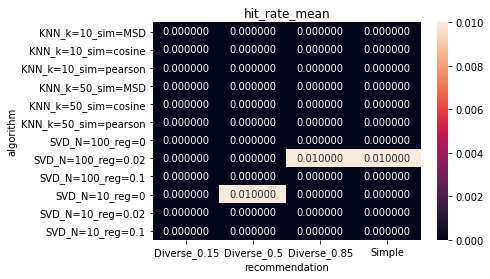

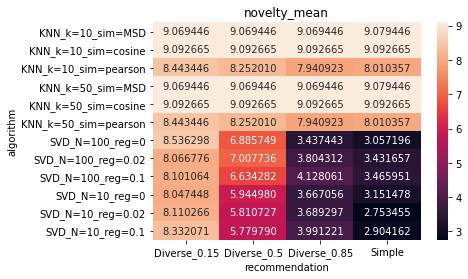

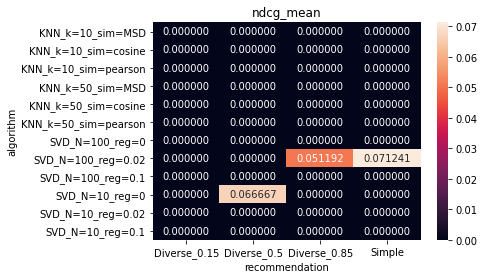

In [16]:
resultsDf = pd.DataFrame({"algorithm": list(map(lambda x: x[0], results)), 
                          "recommendation": list(map(lambda x: x[1], results)), 
                          "hit_rate_mean": list(map(lambda x: x[2][0,0], results)),
                          "novelty_mean": list(map(lambda x: x[2][0,1], results)),
                          "ndcg_mean": list(map(lambda x: x[2][0,2], results)) })
print(resultsDf)
pickBestVariant(resultsDf)

In [51]:
# Use the knn.
algoKNN = KNNBaseline()
algoKNN.fit(trainset)
pred = algoKNN.predict("1","2", clip=False)
print(pred)
print(pred.uid, pred.iid, pred.est)

Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.
user: 1          item: 2          r_ui = None   est = 4.15   {'actual_k': 40, 'was_impossible': False}
1 2 4.148609180175668
